In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pandas_datareader as pdr
%matplotlib inline

## Download Stock Data

In [2]:
import threading

date = '2015-06-15'
ticker_request_case_study = ['TDOC','WD','KNSL','BOMN','APPN']
ticker_request_yahoo_top30 = ['AAPL','MSFT','GOOG','AMZN','FB','TSLA','NVDA','DIS','NVO','AMD','ABNB','GM','NIO','F','RBLX','CRWD','DOCU','BIIB','NOK','AMC','GME','UPST','PSFE','TLRY','BB','PSTH','CLOV','BBBY','MVIS','SAML']
ticker_request_motley_fool_top30 = ['BTC','CMPS','CSTL','CURI','DCBO','GSHD','OM','UPST','CALT','DAVA','FLGT','FTHM','LMND','PUBM','SPT','TTCF','AVIR','BIGC','CELH','DOCN','FVRR','INMD','RETA','SMLR','YALA','AMWL','BTRS','DMTK','FROG','KOD','PGNY','POSH','SKLZ','RWM','VINP']
tickers = []
stocks = {}

def downloadStocks(ticker, date):
    try:
        stocks[ticker] = pdr.get_data_yahoo(ticker,date)
        stocks[ticker].drop('Adj Close', axis=1, inplace=True)
        stocks[ticker].drop('High', axis=1, inplace=True)
        stocks[ticker].drop('Low', axis=1, inplace=True)
        stocks[ticker].drop('Open', axis=1, inplace=True)
        stocks[ticker].drop('Volume', axis=1, inplace=True)
        tickers.append(ticker)
        print("Retrieved %s" % ticker)
    except:
        print("Failed to get %s" % ticker)

threads = []

for ticker in ticker_request_yahoo_top30:
    ticker_thread = threading.Thread(target=downloadStocks, args=(ticker, date,))
    ticker_thread.start()
    threads.append(ticker_thread)

for t in threads:
    t.join()

print(tickers)
stocks[tickers[0]].head()

Retrieved PSFE
Retrieved UPST
Retrieved TLRY
Retrieved CLOV
Retrieved ABNB
Retrieved PSTH
Retrieved AMZNRetrieved RBLX

Retrieved TSLA
Retrieved CRWD
Retrieved NVDA
Retrieved NIO
Retrieved AMD
Retrieved BB
Retrieved BIIB
Retrieved MVIS
Retrieved DIS
Retrieved SAML
Retrieved DOCU
Retrieved AAPLRetrieved MSFT

Retrieved GMERetrieved GOOG

Retrieved BBBYRetrieved NVO

Retrieved FB
Retrieved GM
Retrieved F
Retrieved AMC
Retrieved NOK
['PSFE', 'UPST', 'TLRY', 'CLOV', 'ABNB', 'PSTH', 'AMZN', 'RBLX', 'TSLA', 'CRWD', 'NVDA', 'NIO', 'AMD', 'BB', 'BIIB', 'MVIS', 'DIS', 'SAML', 'DOCU', 'AAPL', 'MSFT', 'GME', 'GOOG', 'BBBY', 'NVO', 'FB', 'GM', 'F', 'AMC', 'NOK']


,Close
Date,
2020-10-09,9.950
2020-10-12,9.860
2020-10-13,9.900
2020-10-14,9.860
2020-10-15,9.805


## Generate Baseline Performance and Moving Average (MA) Performance

In [3]:
def generateSystems(ticker):
    stocks[ticker]['3-day'] = stocks[ticker]['Close'].rolling(3).mean()
    stocks[ticker]['9-day'] = stocks[ticker]['Close'].rolling(9).mean()
    stocks[ticker]['21-day'] = stocks[ticker]['Close'].rolling(21).mean()
    stocks[ticker]['Change'] = np.log(stocks[ticker].Close / stocks[ticker].Close.shift())
    
    # When the faster moving average is moving above the slower one, indicates time to buy
    stocks[ticker]['position-3-9'] = np.where(stocks[ticker]['3-day'] > stocks[ticker]['9-day'], 1,0)
    stocks[ticker]['position-9-21'] = np.where(stocks[ticker]['9-day'] > stocks[ticker]['21-day'], 1,0)
    # When the faster moving average is moving below the slower one, indicates time to sell
    stocks[ticker]['position-3-9'] = np.where(stocks[ticker]['3-day'] < stocks[ticker]['9-day'],-1,stocks[ticker]['position-3-9'])
    stocks[ticker]['position-9-21'] = np.where(stocks[ticker]['9-day'] < stocks[ticker]['21-day'],-1,stocks[ticker]['position-9-21'])
    
    # Whether we are making money with this system
    stocks[ticker]['system-3-9'] = np.where(stocks[ticker]['position-3-9'] > 0, stocks[ticker]['position-3-9']* stocks[ticker]['Change'],0)
    stocks[ticker]['system-9-21'] = np.where(stocks[ticker]['position-9-21'] > 0, stocks[ticker]['position-9-21']* stocks[ticker]['Change'],0)

    stocks[ticker]['Volatility'] = stocks[ticker].Change.rolling(21).std().shift()
    
threads = []

for ticker in tickers:
    ticker_thread = threading.Thread(target=generateSystems, args=(ticker,))
    ticker_thread.start()
    threads.append(ticker_thread)

for t in threads:
    t.join()
    
stocks[tickers[0]].tail()

,Close,3-day,9-day,21-day,Change,position-3-9,position-9-21,system-3-9,system-9-21,Volatility
Date,,,,,,,,,,
2021-05-28,11.22,11.360000,11.705556,12.144286,-0.008873,-1,-1,0.000000,0.0,0.044703
2021-06-01,11.80,11.446667,11.695556,12.049048,0.050402,-1,-1,0.000000,0.0,0.044604
2021-06-02,12.15,11.723333,11.688889,11.965714,0.029230,1,-1,0.029230,0.0,0.046504
2021-06-03,11.82,11.923333,11.661111,11.881429,-0.027536,1,-1,-0.027536,0.0,0.047096
2021-06-04,12.26,12.076667,11.694444,11.832381,0.036549,1,-1,0.036549,0.0,0.047194


## Generate DGIM MA Performance

In [4]:
%reload_ext autoreload
%autoreload 2
from ipynb.fs.full.DGIMMovingAverage import *
import threading

bit_depth = 16
num_buckets = 5

def generateDGIMSystems(ticker):
    stocks_list = stocks[ticker]['Close'].tolist()
    stocks_3day_list = stocks[ticker]['3-day'].tolist()
    stocks_9day_list = stocks[ticker]['9-day'].tolist()
    stocks_21day_list = stocks[ticker]['21-day'].tolist()
    stocks_list_bin = [ np.array(list(np.binary_repr(round(elem)).zfill(bit_depth))).astype(np.int8) for elem in stocks_list ]

    try:
        dgim_3day = DGIMMovingAverage(stocks_list_bin, 3, num_buckets, bit_depth, stocks_3day_list, True)
        stocks[ticker]['3-day-dgim'] = dgim_3day.mov_avg
        dgim_9day = DGIMMovingAverage(stocks_list_bin, 9, num_buckets, bit_depth, stocks_9day_list, True)
        stocks[ticker]['9-day-dgim'] = dgim_9day.mov_avg
        dgim_21day = DGIMMovingAverage(stocks_list_bin, 21, num_buckets, bit_depth, stocks_21day_list, True)
        stocks[ticker]['21-day-dgim'] = dgim_21day.mov_avg

        # When the faster moving average is moving above the slower one, indicates time to buy
        stocks[ticker]['position-dgim-3-9'] = np.where(stocks[ticker]['3-day-dgim'] > stocks[ticker]['9-day-dgim'], 1,0)
        stocks[ticker]['position-dgim-9-21'] = np.where(stocks[ticker]['9-day-dgim'] > stocks[ticker]['21-day-dgim'], 1,0)

        # When the faster moving average is moving below the slower one, indicates time to sell\
        stocks[ticker]['position-dgim-3-9'] = np.where(stocks[ticker]['3-day-dgim'] < stocks[ticker]['9-day-dgim'],-1,stocks[ticker]['position-dgim-3-9'])
        stocks[ticker]['position-dgim-9-21'] = np.where(stocks[ticker]['9-day-dgim'] < stocks[ticker]['21-day-dgim'],-1,stocks[ticker]['position-dgim-9-21'])

        # Whether we are making money with this system
        stocks[ticker]['system-dgim-3-9'] = np.where(stocks[ticker]['position-dgim-3-9'] > 0, stocks[ticker]['position-dgim-3-9']* stocks[ticker]['Change'],0)
        stocks[ticker]['system-dgim-9-21'] = np.where(stocks[ticker]['position-dgim-9-21'] > 0, stocks[ticker]['position-dgim-9-21']* stocks[ticker]['Change'],0)
        
        print("Finished %s" % ticker)
    except Exception as e:
        print("Failed to analyze %s" % ticker, e)
        tickers.remove(ticker)

threads = []

for ticker in tickers:
    ticker_thread = threading.Thread(target=generateDGIMSystems, args=(ticker,))
    ticker_thread.start()
    threads.append(ticker_thread)

for t in threads:
    t.join()

Finished RBLX
Finished CLOV
Finished ABNB
Finished UPST
Finished PSFE
Finished PSTH
Finished CRWD
Finished NIO
Finished TLRY
Finished DOCU
Finished SAML
Finished BB
Finished AMC
Finished NVDA
Finished BIIB
Finished GME
Finished NOK
Finished MVIS
Finished AAPLFinished MSFT

Finished DIS
Finished GM
Finished GOOG
Finished NVO
Finished FB
Finished TSLA
Finished BBBY
Finished AMZN
Finished AMD
Finished F


## Generate Normalized DGIM MA Performance

In [5]:
def normalizeDGIM(ticker):
    try:
        stocks[ticker]['3-day-dgim-norm']=(stocks[ticker]['3-day-dgim']-stocks[ticker]['3-day-dgim'].mean())/stocks[ticker]['3-day-dgim'].std()
        stocks[ticker]['9-day-dgim-norm']=(stocks[ticker]['9-day-dgim']-stocks[ticker]['9-day-dgim'].mean())/stocks[ticker]['9-day-dgim'].std()
        stocks[ticker]['21-day-dgim-norm']=(stocks[ticker]['21-day-dgim']-stocks[ticker]['21-day-dgim'].mean())/stocks[ticker]['21-day-dgim'].std()

        # When the faster moving average is moving above the slower one, indicates time to buy
        stocks[ticker]['position-dgim-3-9-norm'] = np.where(stocks[ticker]['3-day-dgim-norm'] > stocks[ticker]['9-day-dgim-norm'], 1,0)
        stocks[ticker]['position-dgim-9-21-norm'] = np.where(stocks[ticker]['9-day-dgim-norm'] > stocks[ticker]['21-day-dgim-norm'], 1,0)
        # When the faster moving average is moving below the slower one, indicates time to sell
        stocks[ticker]['position-dgim-3-9-norm'] = np.where(stocks[ticker]['3-day-dgim-norm'] < stocks[ticker]['9-day-dgim-norm'],-1,stocks[ticker]['position-dgim-3-9-norm'])
        stocks[ticker]['position-dgim-9-21-norm'] = np.where(stocks[ticker]['9-day-dgim-norm'] < stocks[ticker]['21-day-dgim-norm'],-1,stocks[ticker]['position-dgim-9-21-norm'])

        # Whether we are making money with this system
        stocks[ticker]['system-dgim-3-9-norm'] = np.where(stocks[ticker]['position-dgim-3-9-norm'] > 0, stocks[ticker]['position-dgim-3-9-norm']* stocks[ticker]['Change'],0)
        stocks[ticker]['system-dgim-9-21-norm'] = np.where(stocks[ticker]['position-dgim-9-21-norm'] > 0, stocks[ticker]['position-dgim-9-21-norm']* stocks[ticker]['Change'],0)
    except:
        pass

threads = []

for ticker in tickers:
    ticker_thread = threading.Thread(target=normalizeDGIM, args=(ticker,))
    ticker_thread.start()
    threads.append(ticker_thread)

for t in threads:
    t.join()
    
stocks[tickers[0]].tail()

,Close,3-day,9-day,21-day,Change,position-3-9,position-9-21,system-3-9,system-9-21,Volatility,...,position-dgim-9-21,system-dgim-3-9,system-dgim-9-21,3-day-dgim-norm,9-day-dgim-norm,21-day-dgim-norm,position-dgim-3-9-norm,position-dgim-9-21-norm,system-dgim-3-9-norm,system-dgim-9-21-norm
Date,,,,,,,,,,,,,,,,,,,,,
2021-05-28,11.22,11.360000,11.705556,12.144286,-0.008873,-1,-1,0.000000,0.0,0.044703,...,-1,0.0,0.0,-0.463846,-0.817556,-0.852833,1,1,-0.008873,-0.008873
2021-06-01,11.80,11.446667,11.695556,12.049048,0.050402,-1,-1,0.000000,0.0,0.044604,...,-1,0.0,0.0,-0.463846,-0.817556,-0.906867,1,1,0.050402,0.050402
2021-06-02,12.15,11.723333,11.688889,11.965714,0.029230,1,-1,0.029230,0.0,0.046504,...,-1,0.0,0.0,-0.345308,-0.817556,-0.960901,1,1,0.029230,0.029230
2021-06-03,11.82,11.923333,11.661111,11.881429,-0.027536,1,-1,-0.027536,0.0,0.047096,...,-1,0.0,0.0,-0.700923,-0.817556,-1.014935,1,1,-0.027536,-0.027536
2021-06-04,12.26,12.076667,11.694444,11.832381,0.036549,1,-1,0.036549,0.0,0.047194,...,-1,0.0,0.0,-0.700923,-0.817556,-1.041953,1,1,0.036549,0.036549


## View Individual Stocks DGIM/Normalized DGIM MA vs. Baseline and MA Performance

/usr/local/Cellar/jupyterlab/3.0.16/libexec/lib/python3.9/site-packages/pandas/plotting/_matplotlib/core.py:337: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


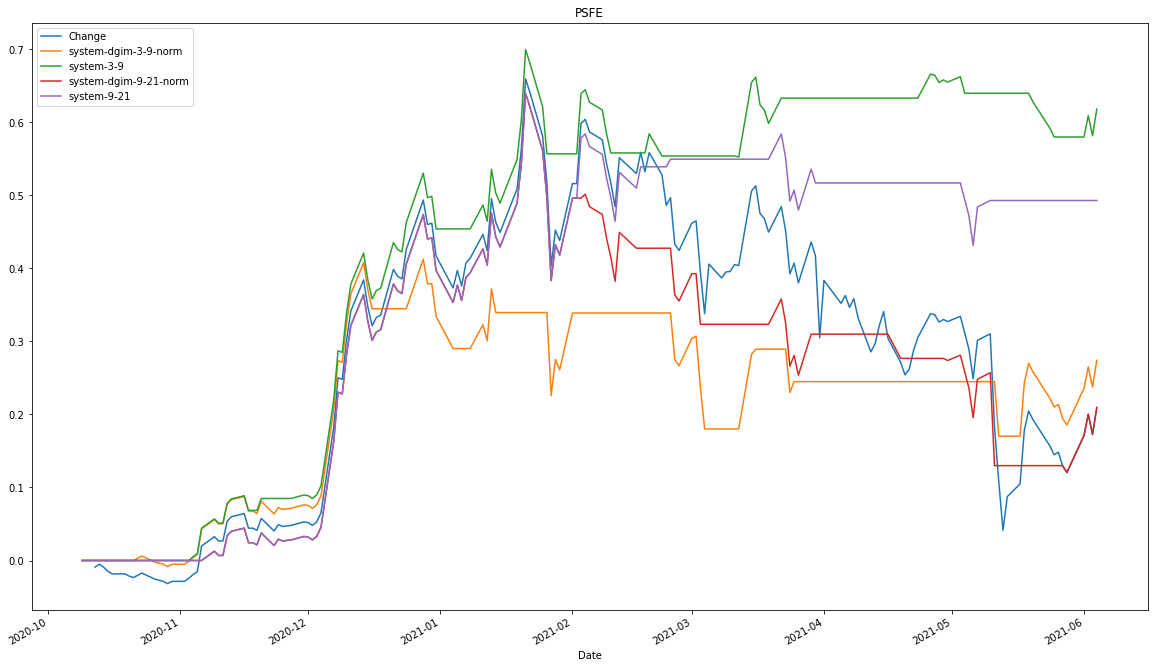

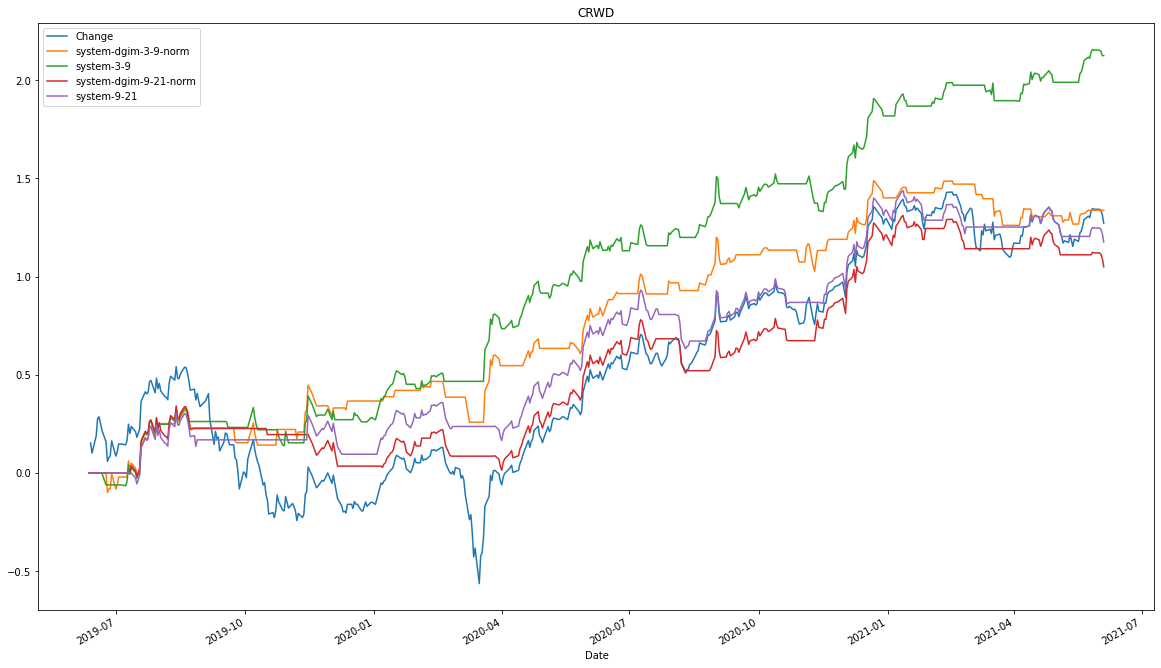

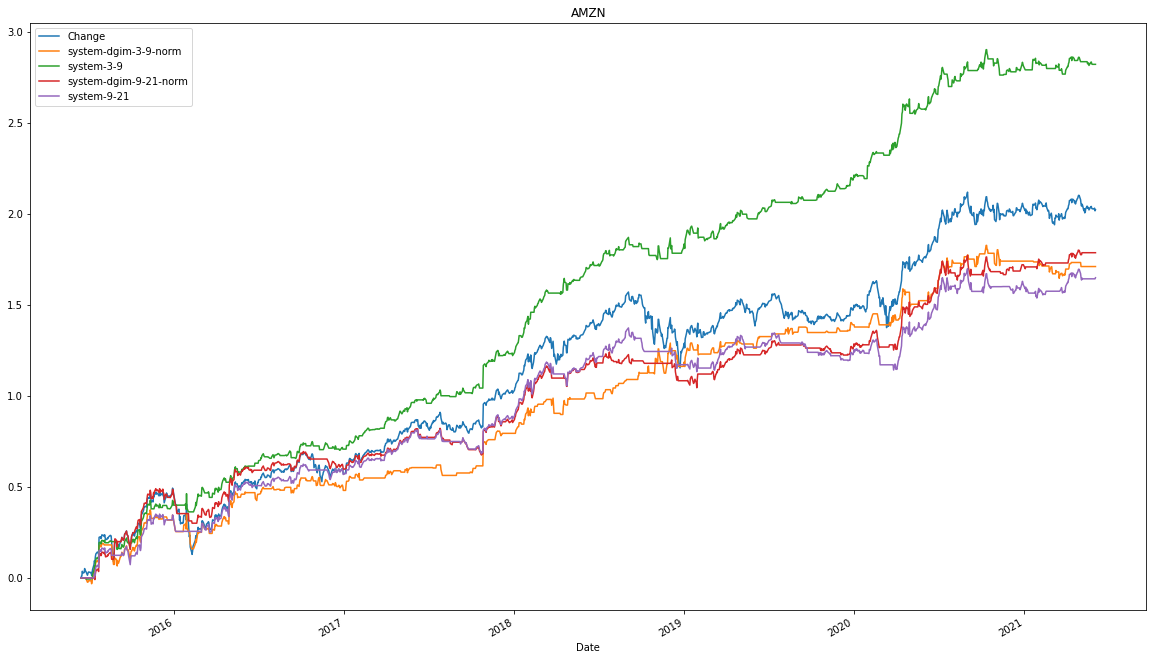

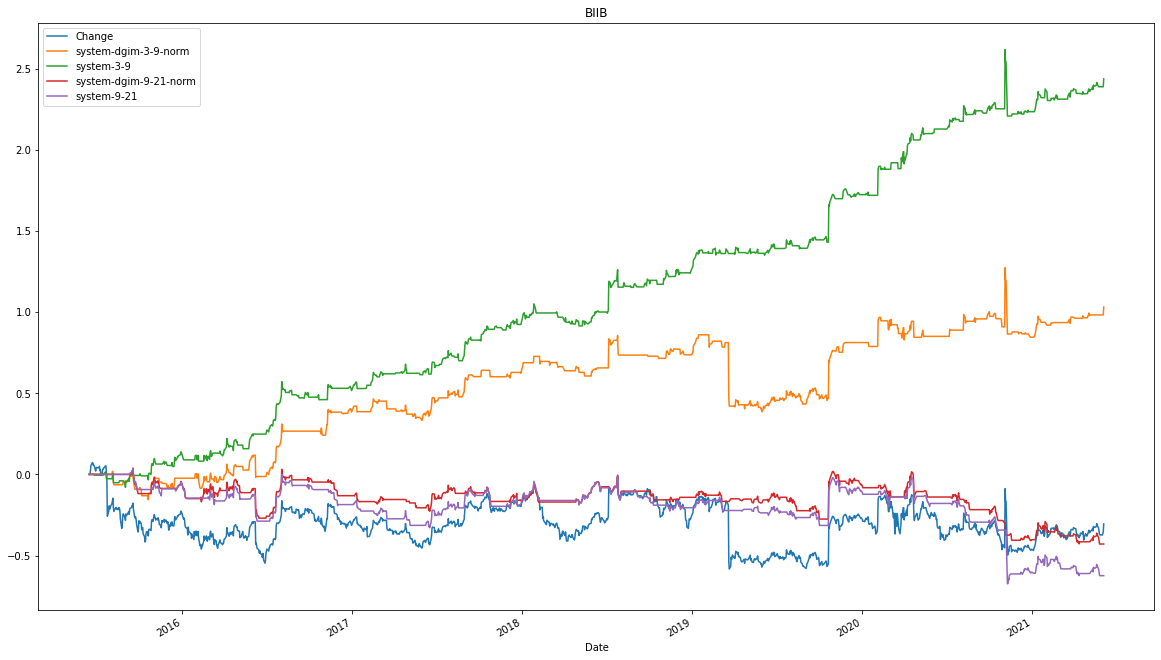

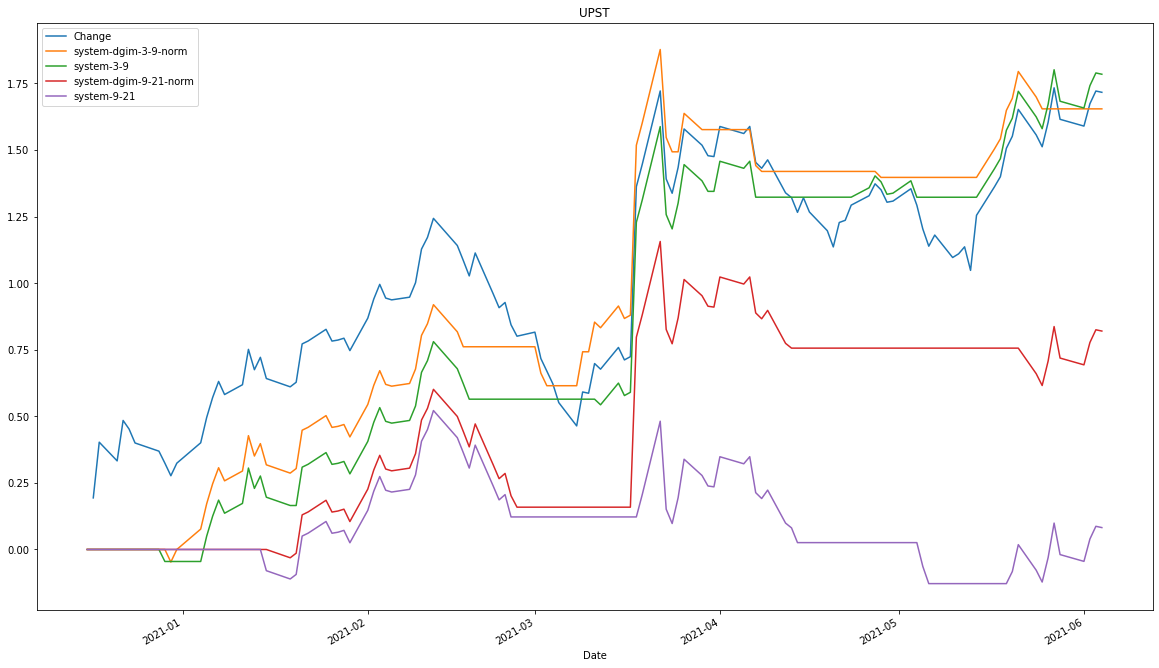

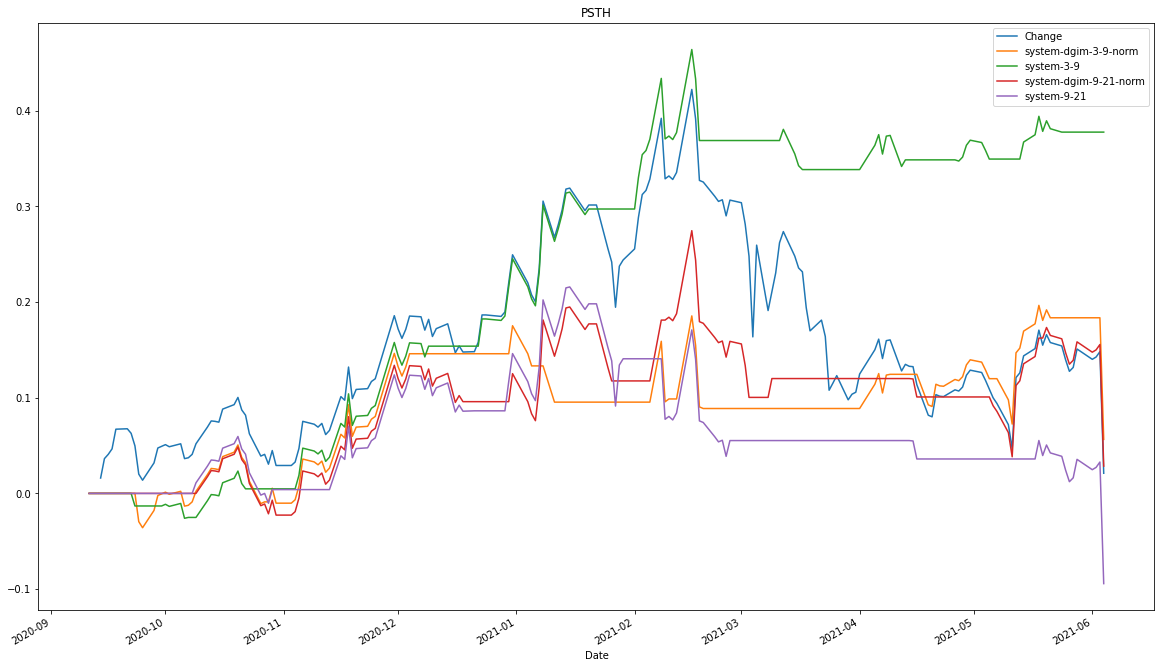

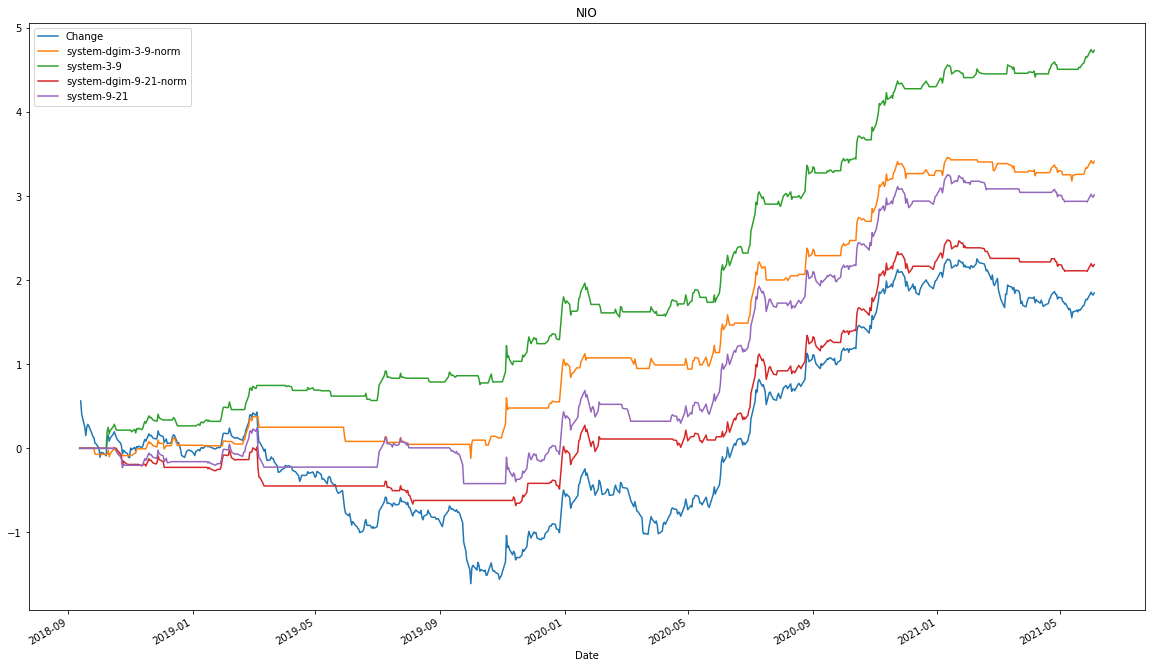

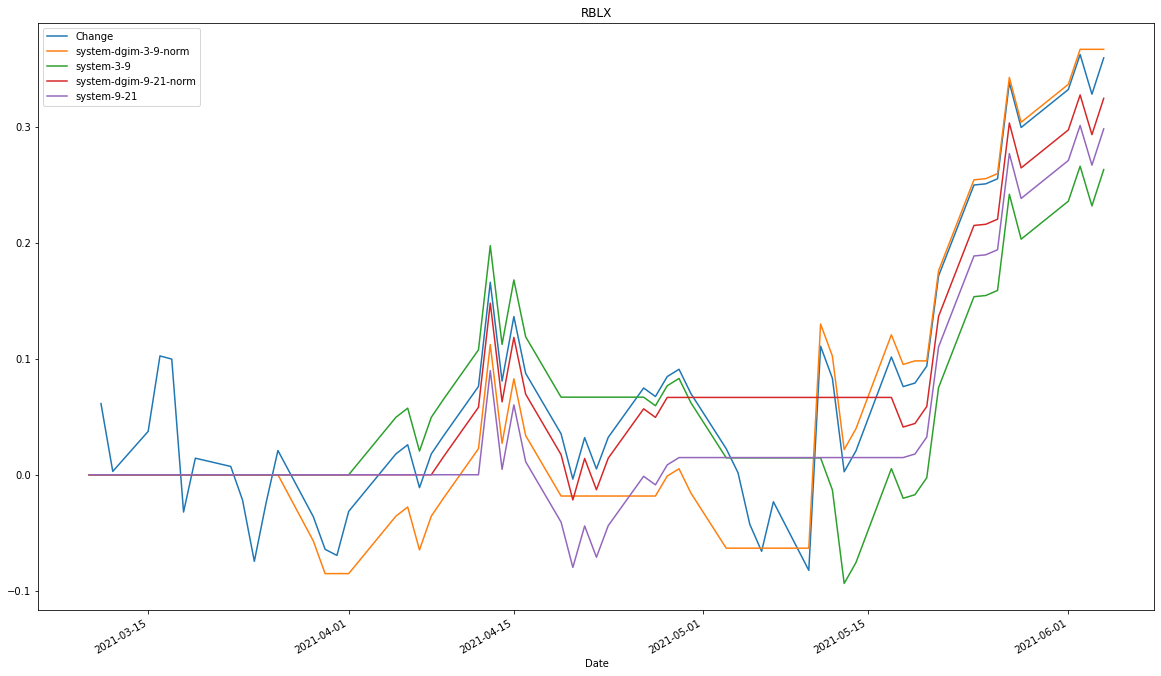

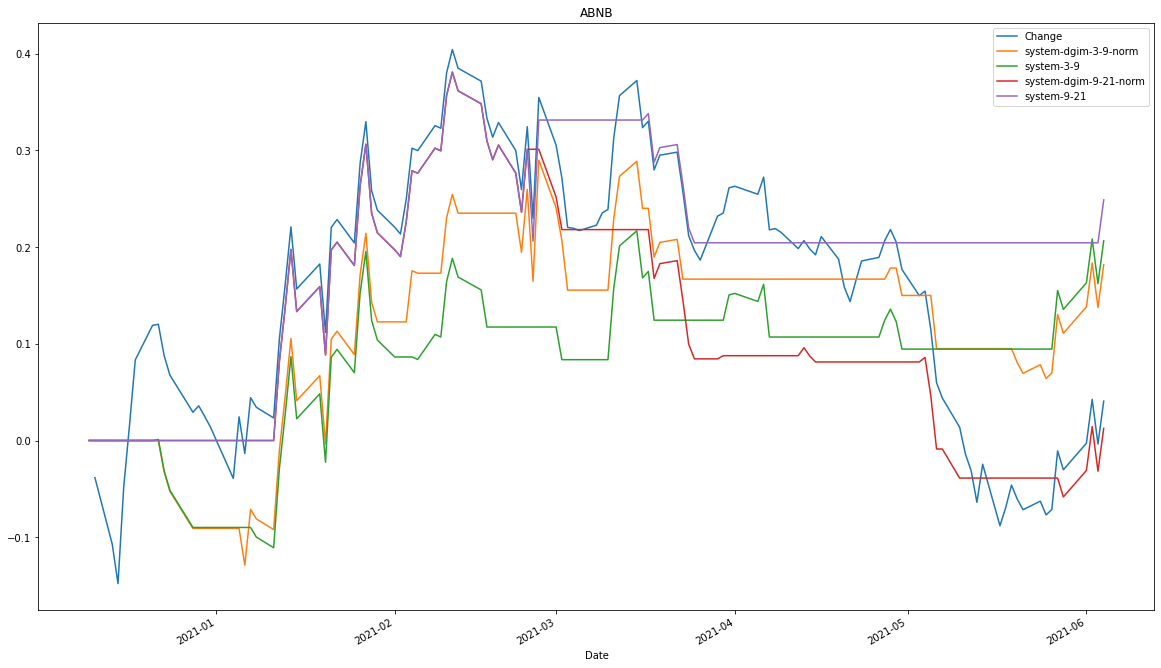

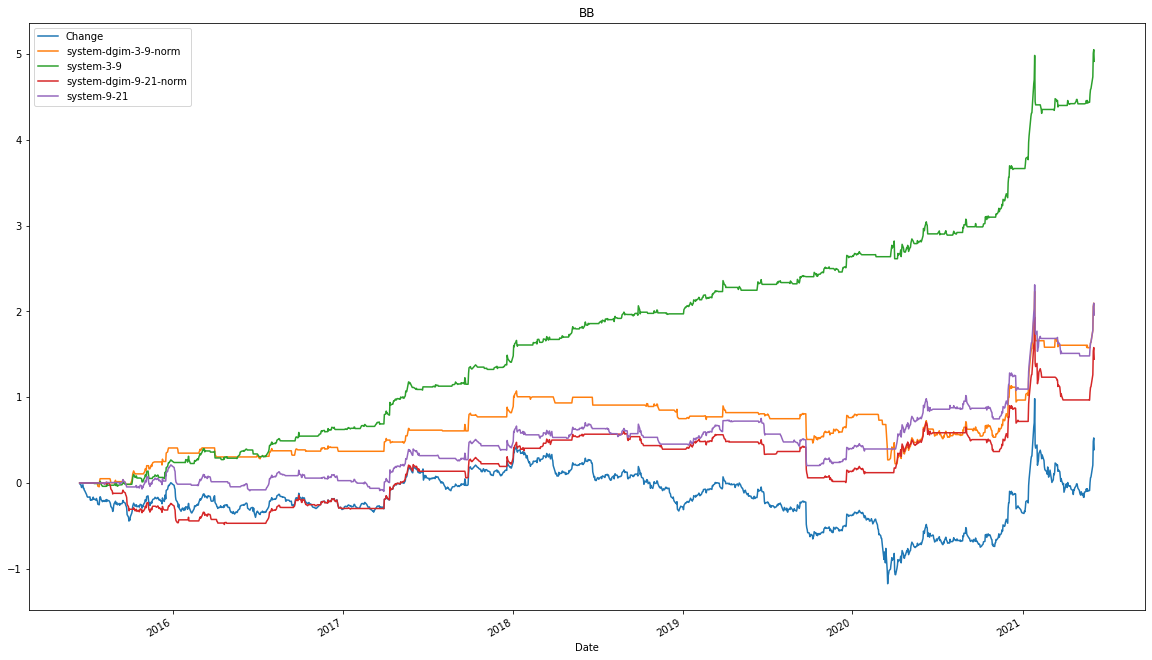

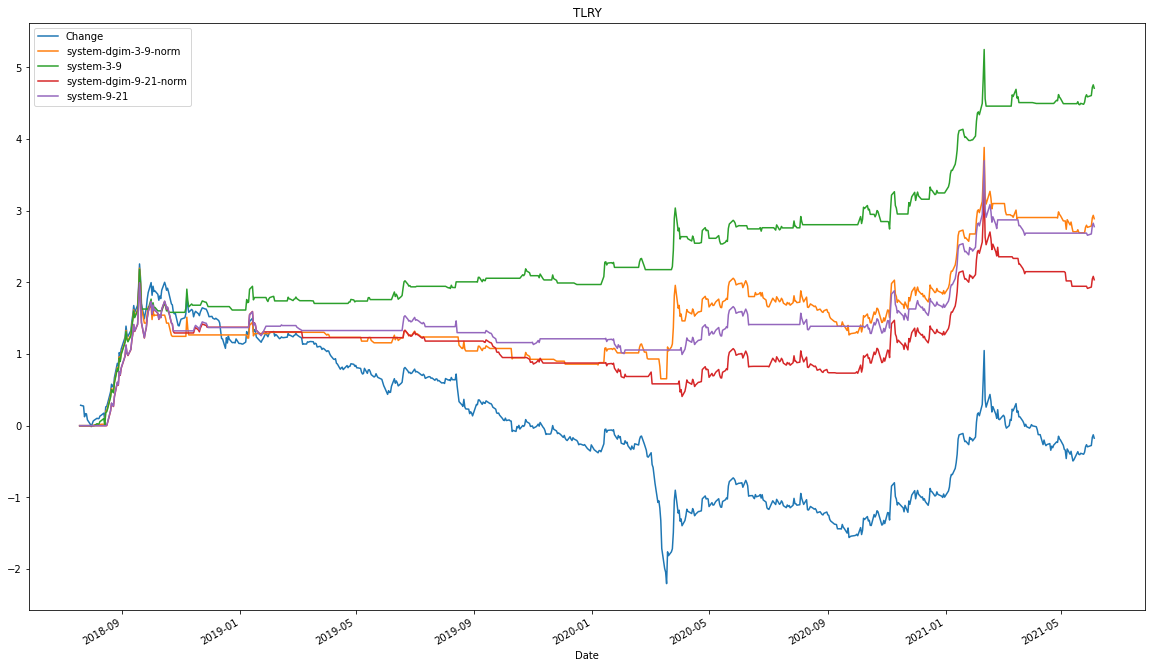

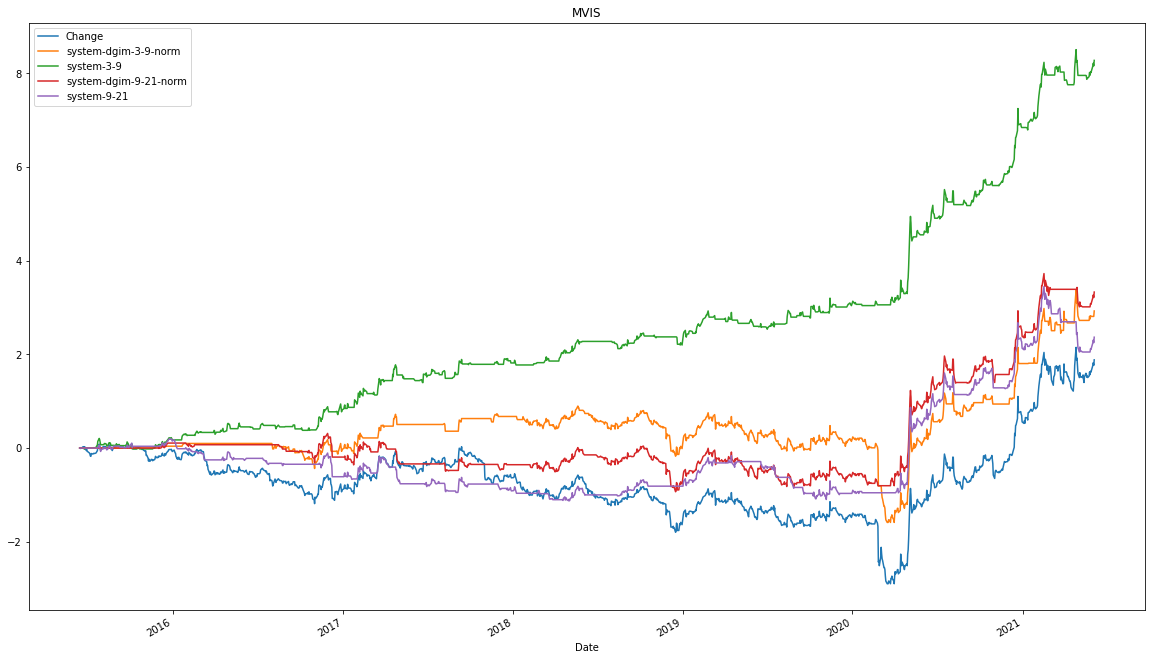

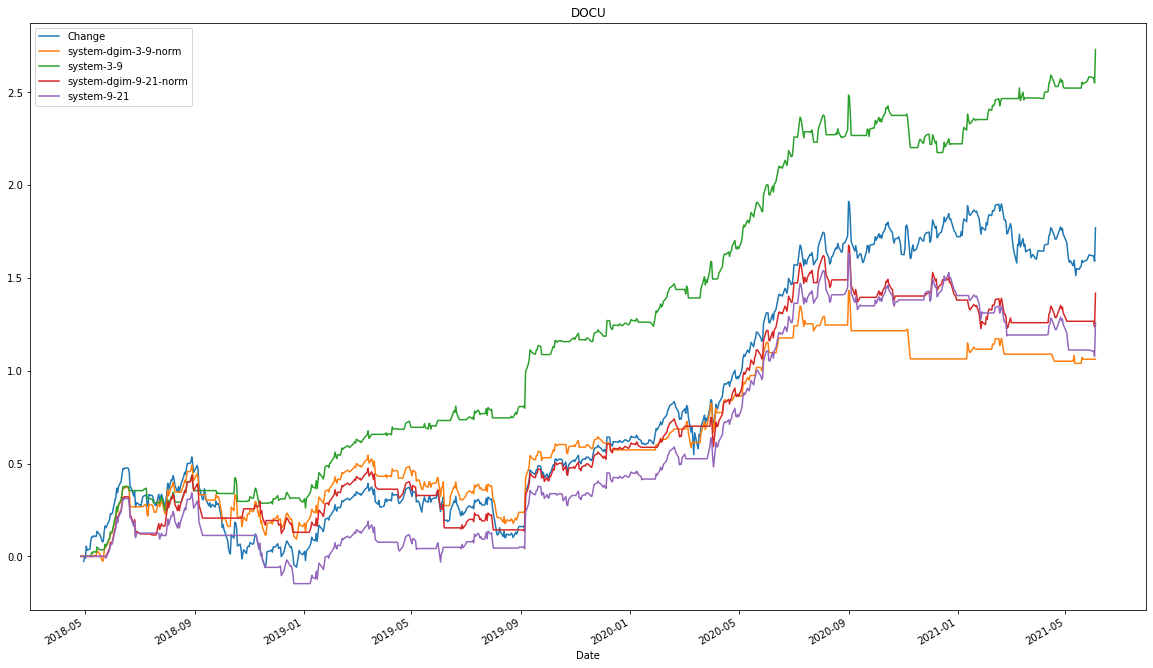

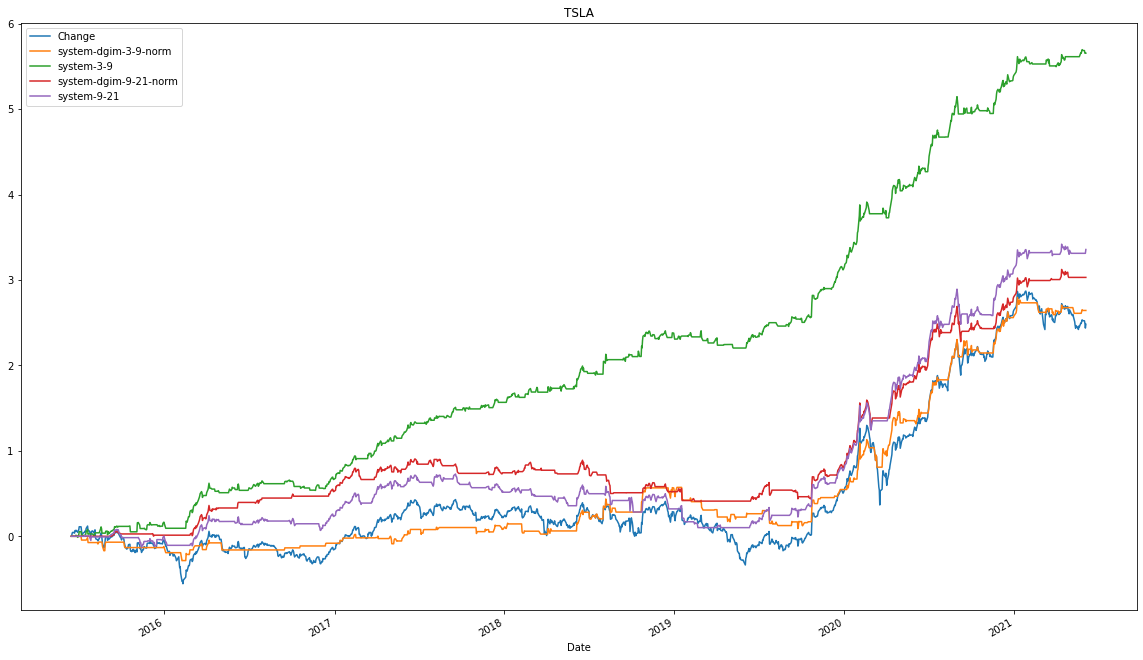

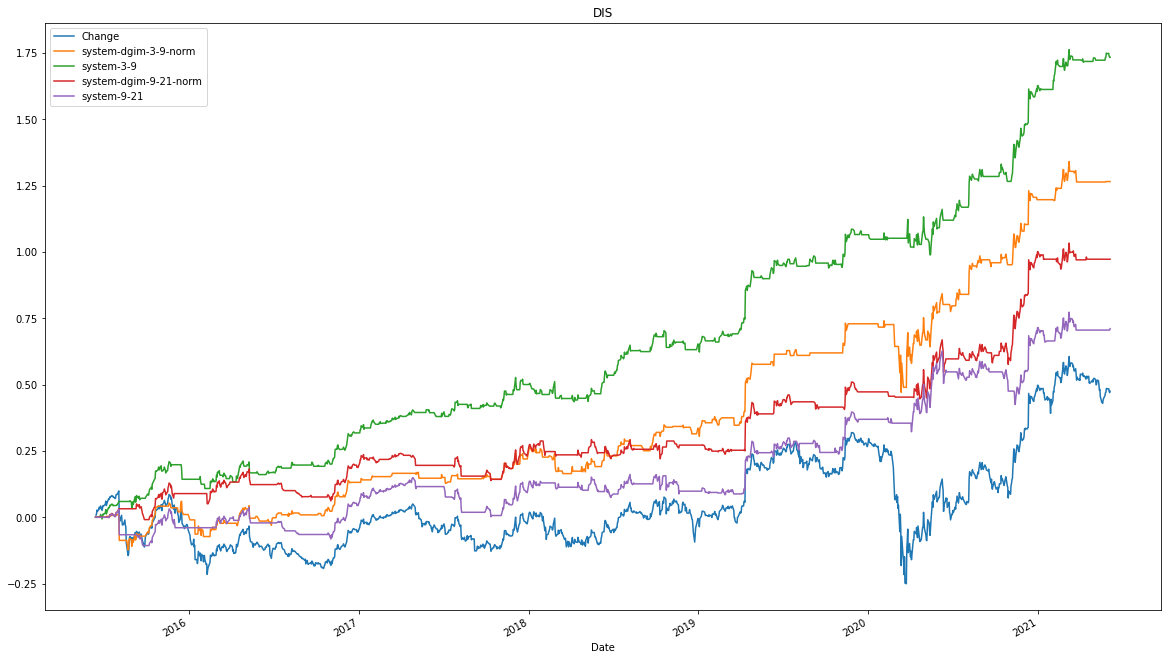

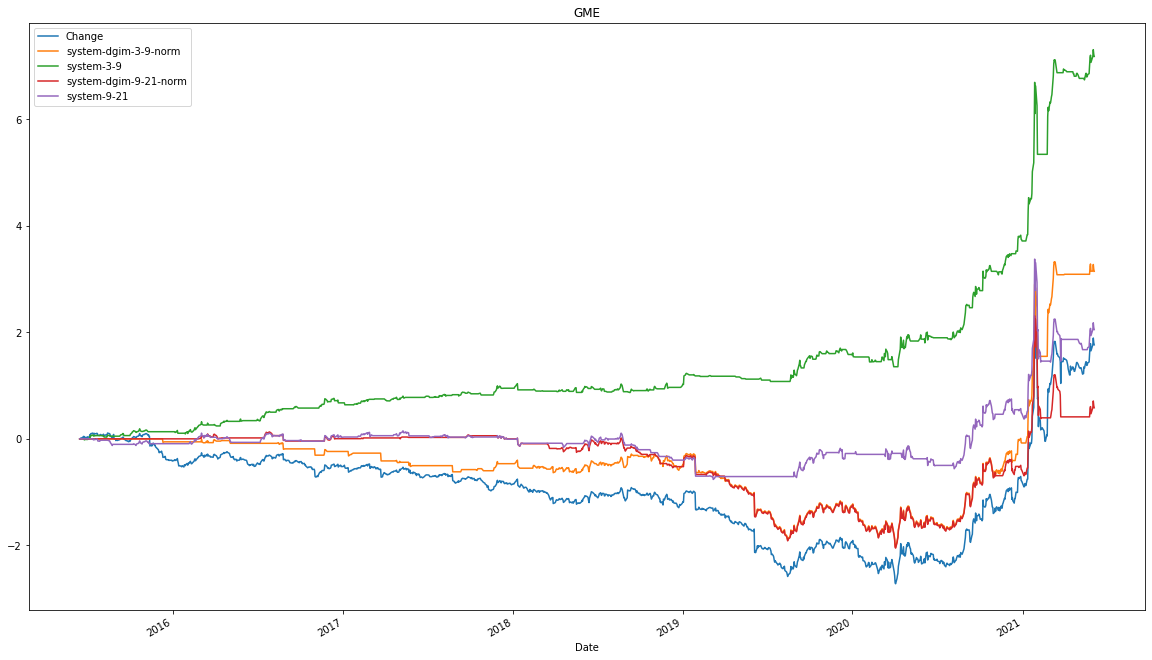

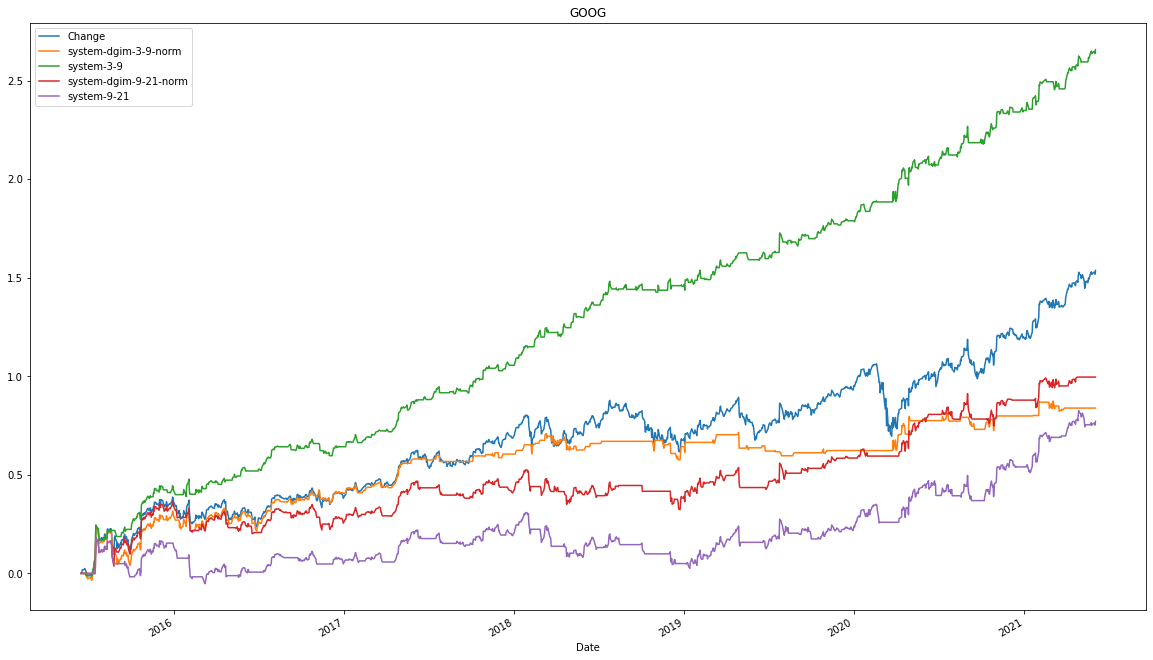

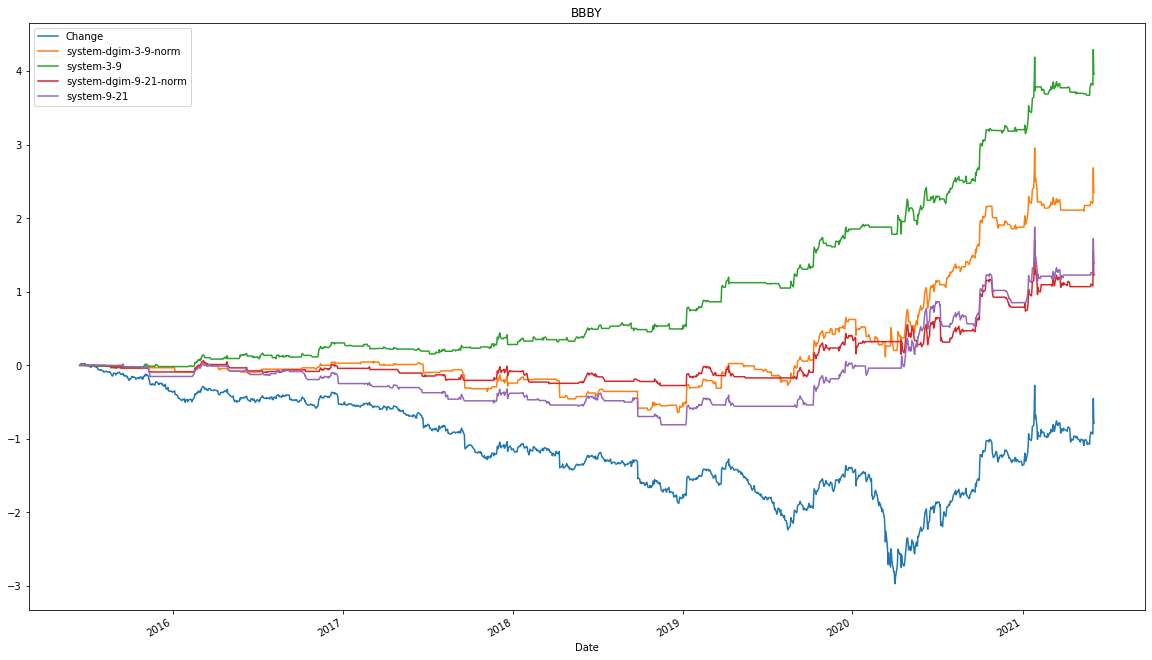

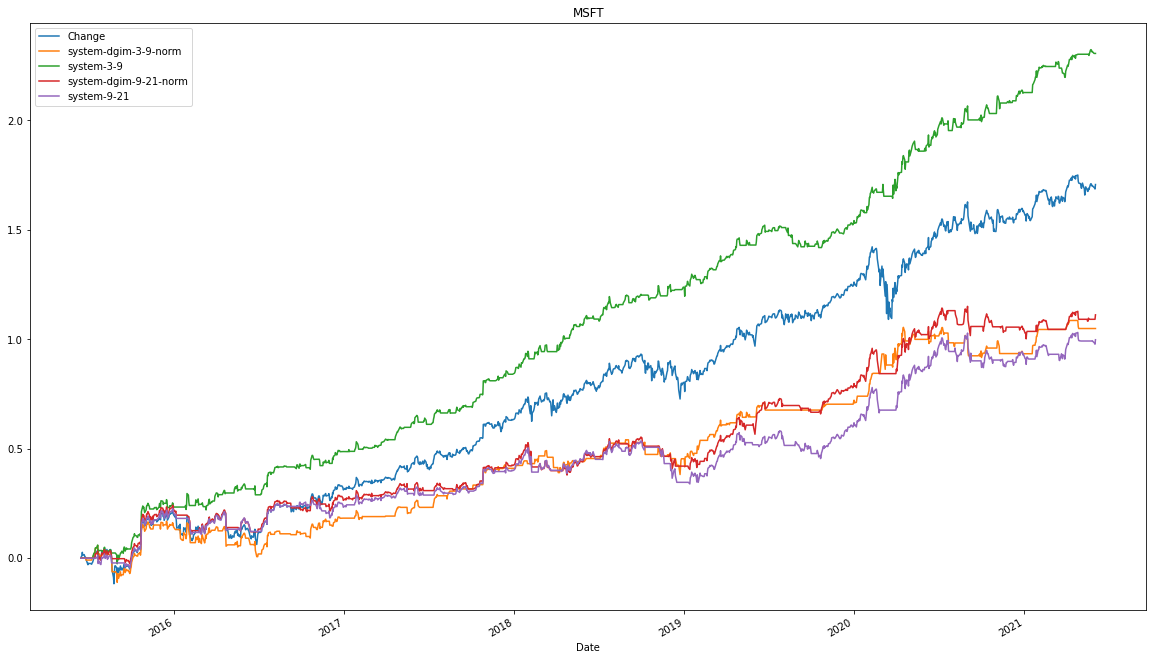

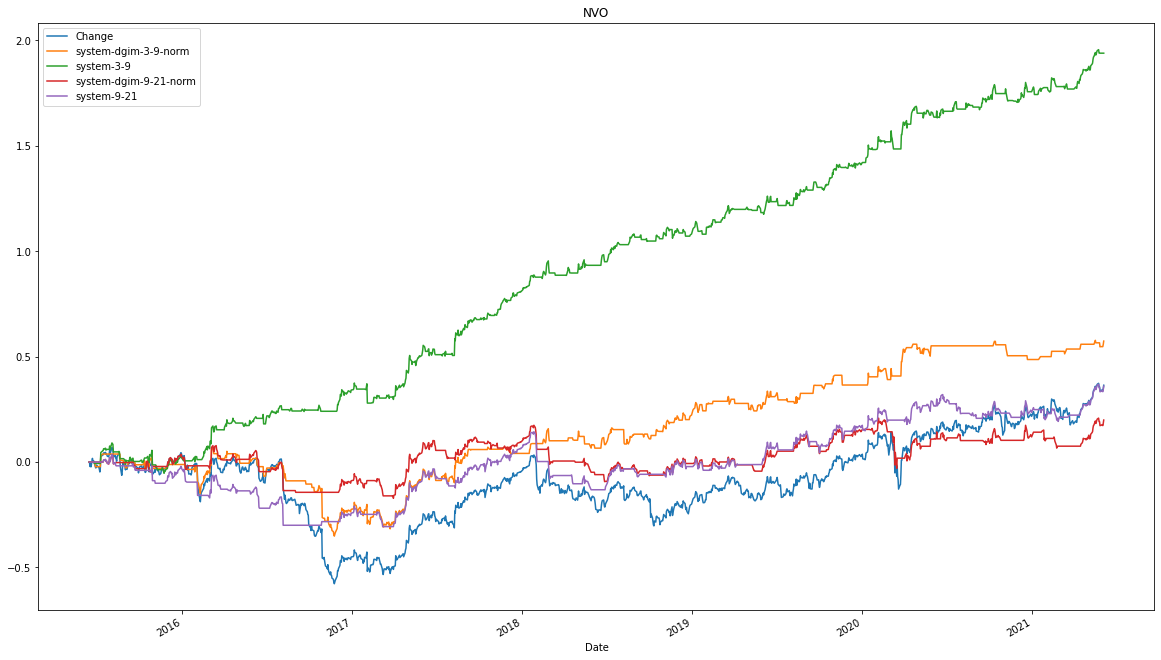

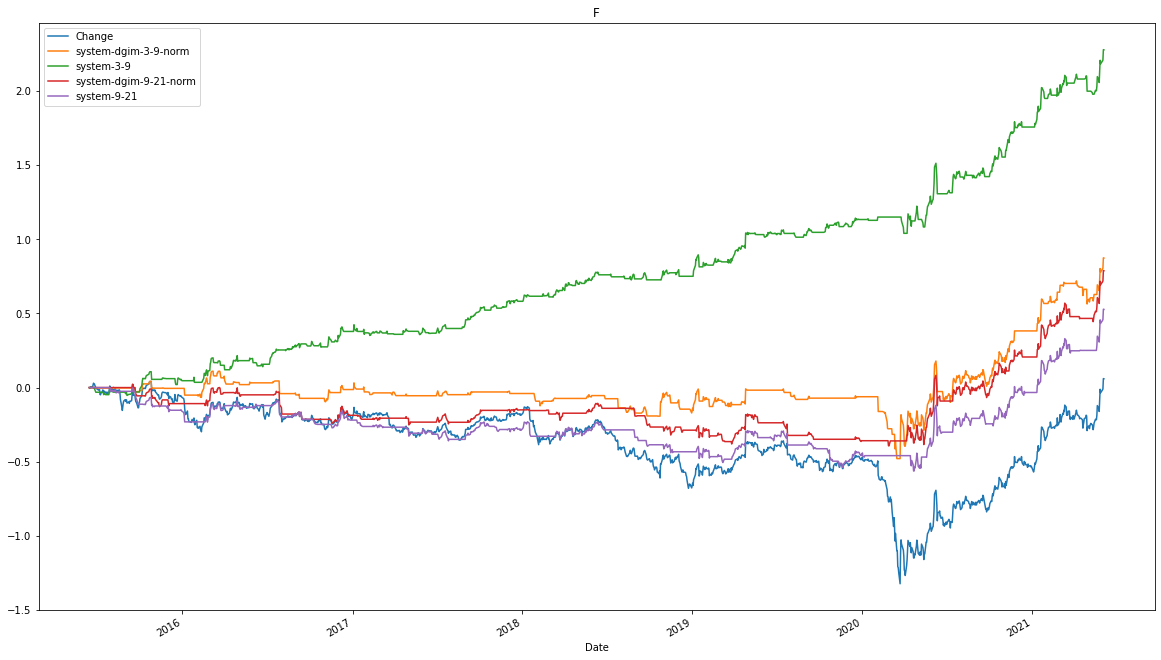

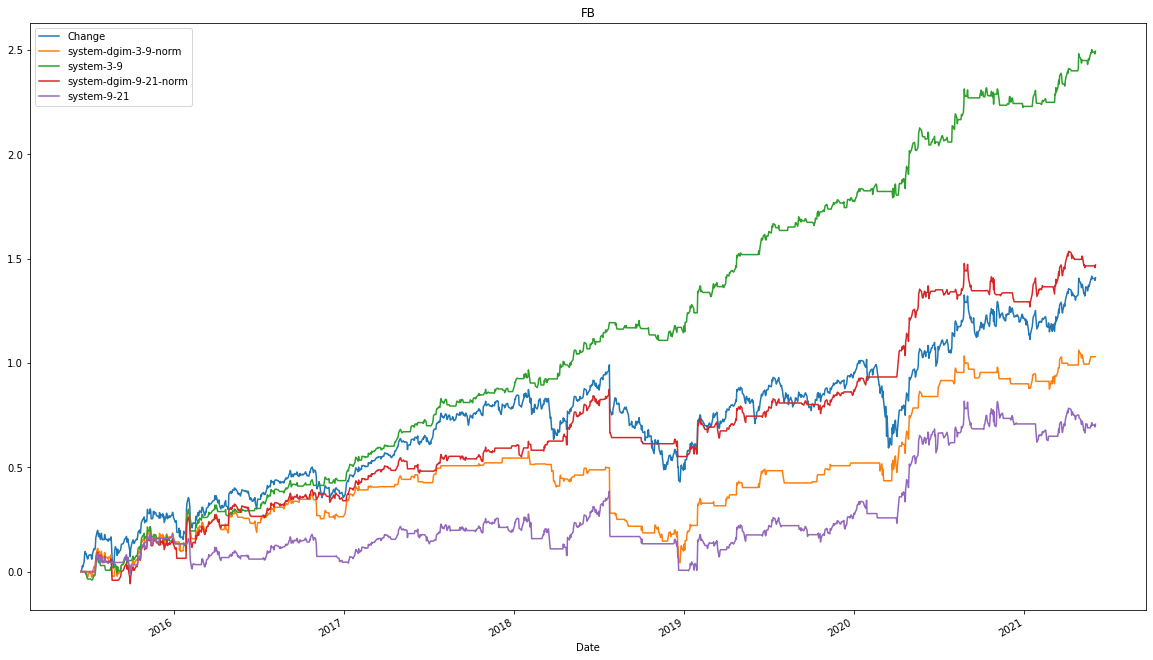

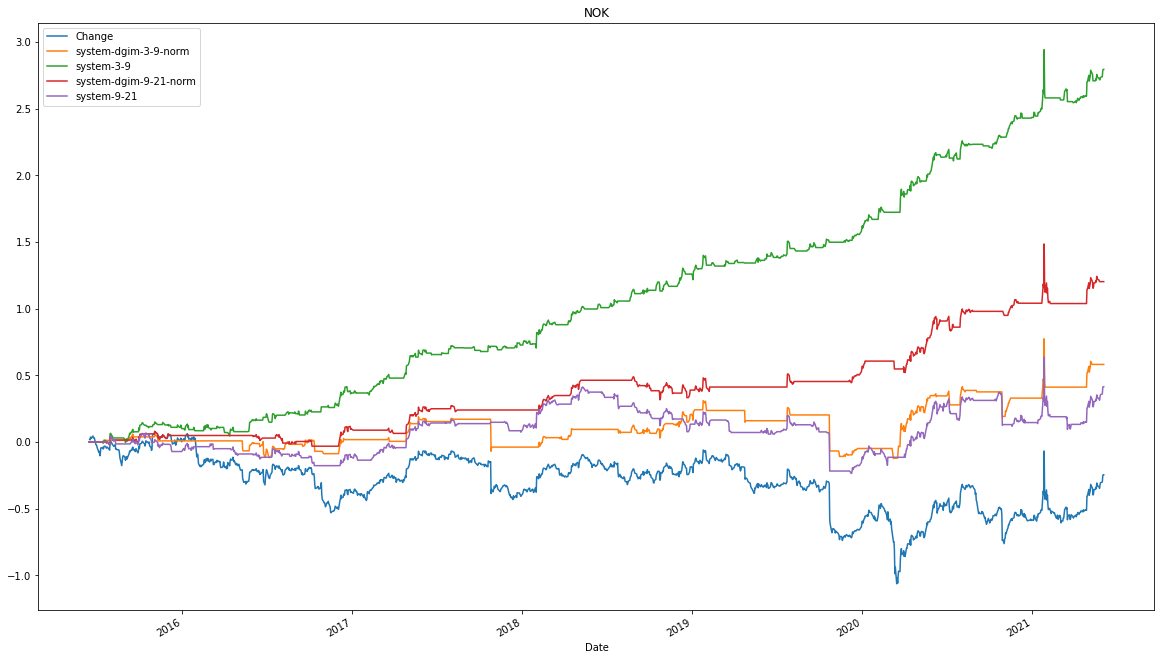

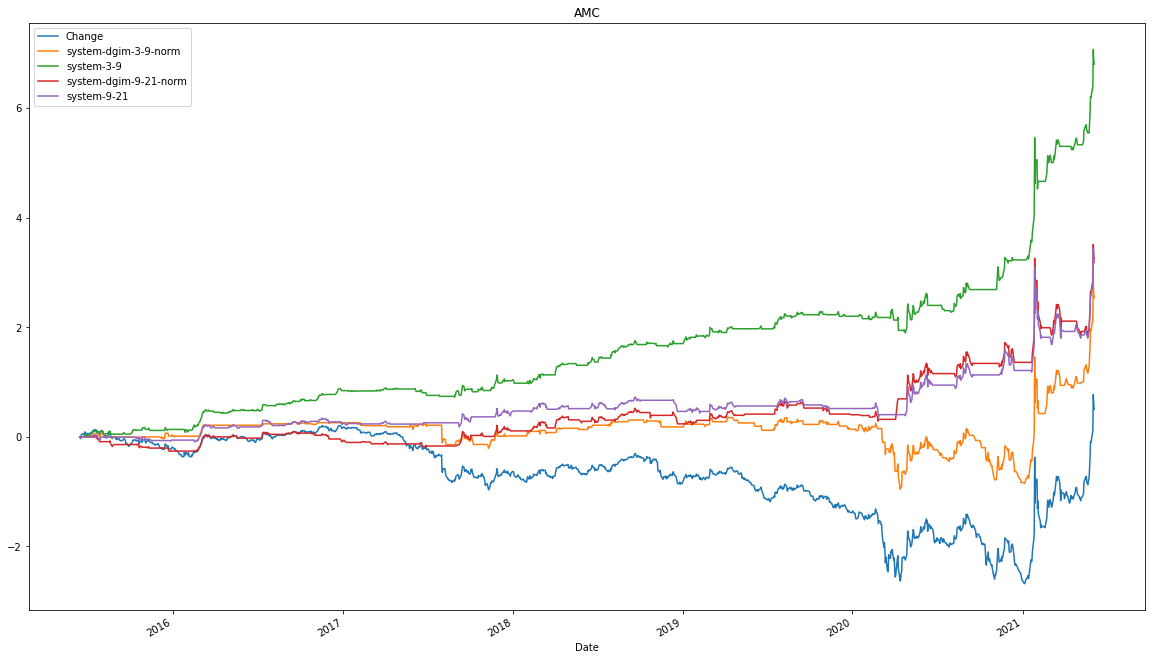

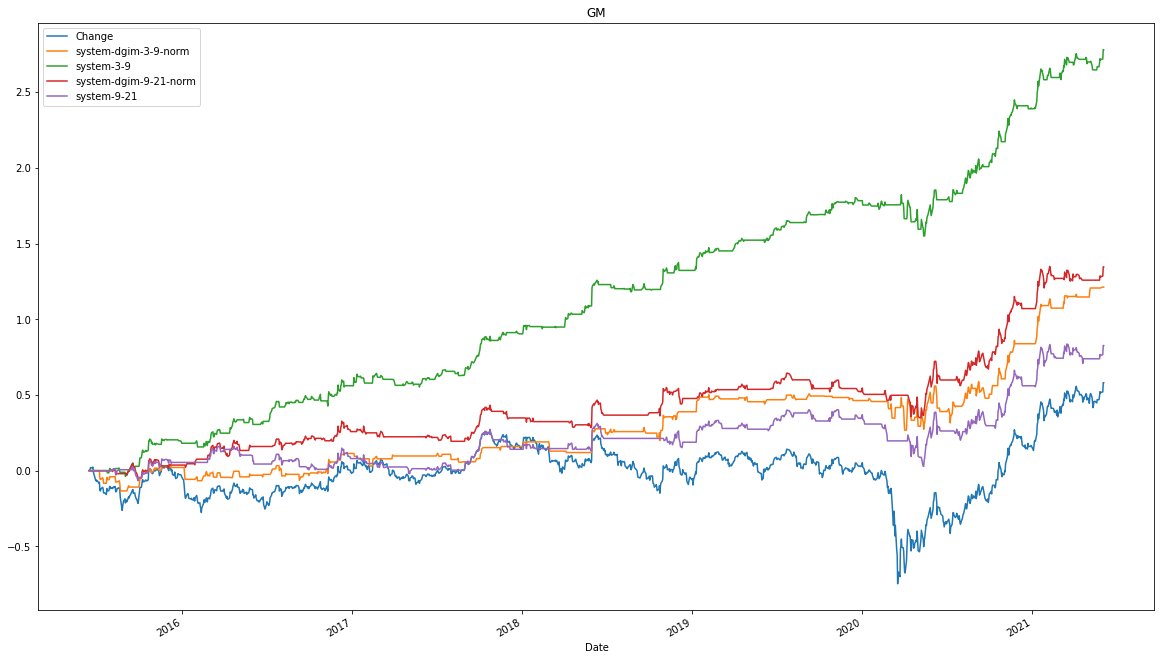

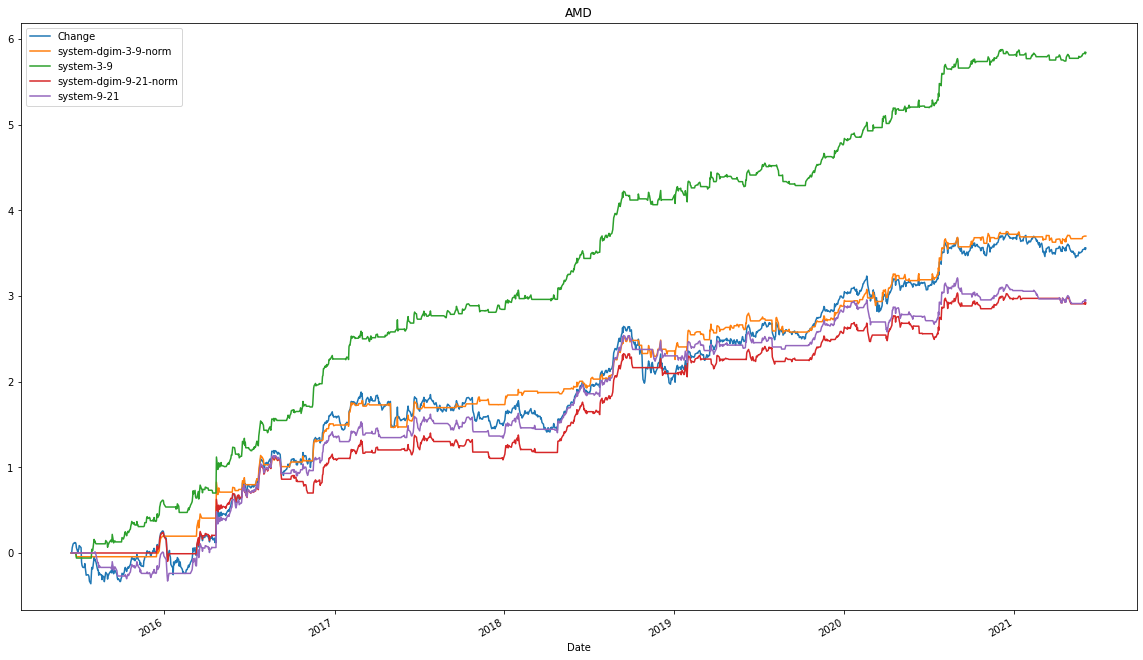

In [6]:
def printSystems(ticker):
    stocks[ticker][['Change','system-dgim-3-9-norm','system-3-9','system-dgim-9-21-norm','system-9-21']].cumsum().plot(title=ticker,figsize=(20,12))

threads = []

for ticker in tickers:
    ticker_thread = threading.Thread(target=printSystems, args=(ticker,))
    ticker_thread.start()
    threads.append(ticker_thread)

for t in threads:
    t.join()

## View Accumulated Performance

,Change,system-dgim-3-9-norm,system-3-9,system-dgim-9-21-norm,system-9-21
2021-06-03,21.121167,47.380786,98.079503,40.142559,39.749982
2021-06-04,21.330747,47.248550,98.347852,40.209150,39.855510
2021-06-05,21.330747,47.248550,98.347852,40.209150,39.855510
2021-06-06,21.330747,47.248550,98.347852,40.209150,39.855510
2021-06-07,21.330747,47.248550,98.347852,40.209150,39.855510


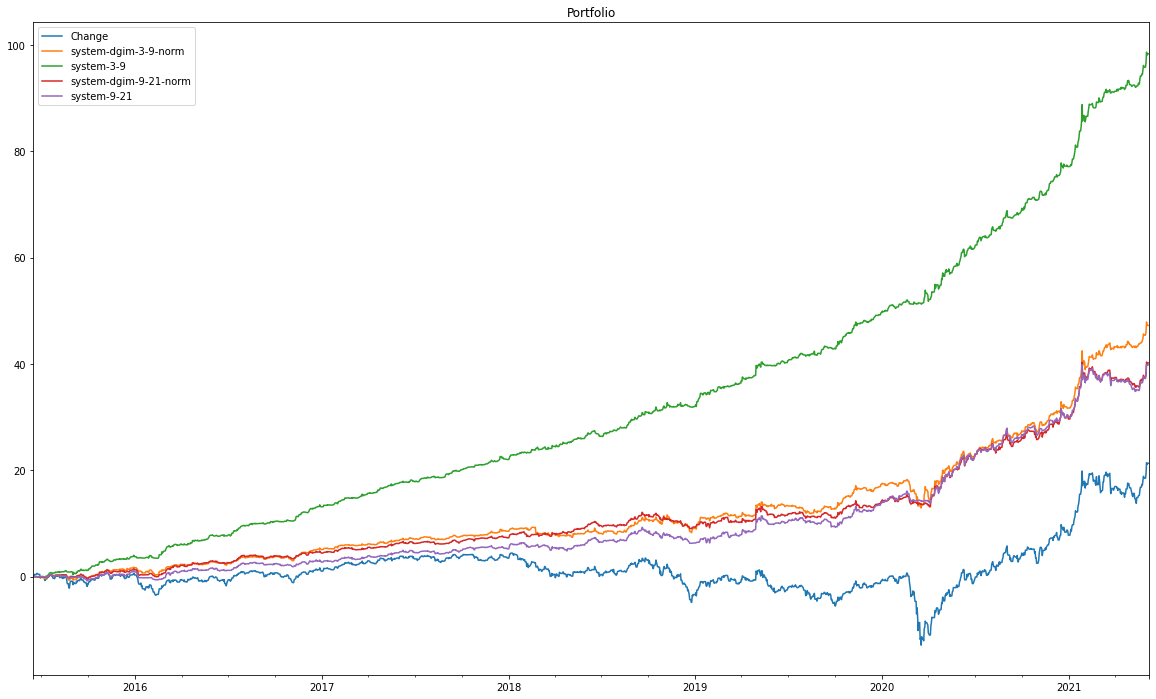

In [7]:
portfolio = 0
for ticker in tickers:
    idx = pd.date_range(date, pd.to_datetime('today'))
    portfolio += stocks[ticker].reindex(idx, fill_value=0)

portfolio[['Change','system-dgim-3-9-norm','system-3-9','system-dgim-9-21-norm','system-9-21']].cumsum().fillna(method ='pad').plot(title="Portfolio",figsize=(20,12))
portfolio[['Change','system-dgim-3-9-norm','system-3-9','system-dgim-9-21-norm','system-9-21']].cumsum().tail()

## Determine Mean Difference for MA and Normalized DGIM MA Performance against Baseline

In [8]:
analysis = []
for ticker in tickers:
    analysis.append({"gain-3-9": stocks[ticker]['system-3-9'].cumsum().tail(1)[0],
                     "gain-9-21": stocks[ticker]['system-9-21'].cumsum().tail(1)[0],
                     "gain-dgim-3-9-norm": stocks[ticker]['system-dgim-3-9-norm'].cumsum().tail(1)[0],
                     "gain-dgim-9-21-norm": stocks[ticker]['system-dgim-9-21-norm'].cumsum().tail(1)[0],
                     "change": stocks[ticker]['Change'].cumsum().tail(1)[0]})
analysisDf = pd.DataFrame(analysis)

meanDifference_3_9 = (analysisDf['gain-3-9'] - analysisDf['change']).mean()
meanDifference_9_21 = (analysisDf['gain-9-21'] - analysisDf['change']).mean()
meanDifference_dgim_3_9_norm = (analysisDf['gain-dgim-3-9-norm'] - analysisDf['change']).mean()
meanDifference_dgim_9_21_norm = (analysisDf['gain-dgim-9-21-norm'] - analysisDf['change']).mean()
print("meanDifference_3_9:",meanDifference_3_9)
print("meanDifference_9_21:", meanDifference_9_21)
print("meanDifference_dgim_3_9_norm:", meanDifference_dgim_3_9_norm)
print("meanDifference_dgim_9_21_norm:", meanDifference_dgim_9_21_norm)

meanDifference_3_9: 2.510856401480887
meanDifference_9_21: 0.5611116559331091
meanDifference_dgim_3_9_norm: 0.8075463213948151
meanDifference_dgim_9_21_norm: 0.5728996742279566
